#  Sensitivity application on respirometry

In [4]:
%matplotlib inline

In [5]:
import os
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import LinearLocator, MaxNLocator
sns.set_style('whitegrid')

In [6]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16 

In [7]:
import pystran as pyst
import hydropy as hp

In [8]:
# Load the Respiromodel
from respiromodel import Respiro

## Reference respirometric model implementation

In [9]:
from biointense.model import Model
from biointense.measurements import ode_measurements
from biointense.optimisation import ParameterOptimisation
from biointense.sensitivity import NumericalLocalSensitivity

In [27]:
system = {'dS': '-(1. - exp(-t/tau))*(1/Y)*mumax*S/(S+ks)*X',
          'dX': '(1. - exp(-t/tau))*(1/Y)*mumax*S/(S+ks)*X - b*X',
          'dDO': '369.73*(8.4-DO)-((1-Y)/Y)*(1.0 - exp(-t/tau))*mumax*S/(S+ks)*X',
          'OURex': '((1.- exp(-t/tau))*mumax*(1-Y)/Y*S/(S+ks)*X)/(24.*60.)'}

parameters = {'mumax': 4., 'ks': 0.4, 'b': 0.62, 'Y': 0.78,
              'tau':2.25e-04}

timestepping = np.linspace(0, 0.05, 1000)
respiro_model = Model('Respirometry', system, parameters)
respiro_model.set_independent({'t': timestepping})
respiro_model.set_initial({'S': 58.48, 'X': 675, 'DO':8.4})

respiro_model.initialize_model()
output = respiro_model.run()
#axs = output.plot(subplots=True, figsize=(12, 8))
#output.index = timestepping

In [28]:
58.58/675

0.08678518518518519

In [29]:
1/12.

0.08333333333333333

In [30]:
output.index=timestepping

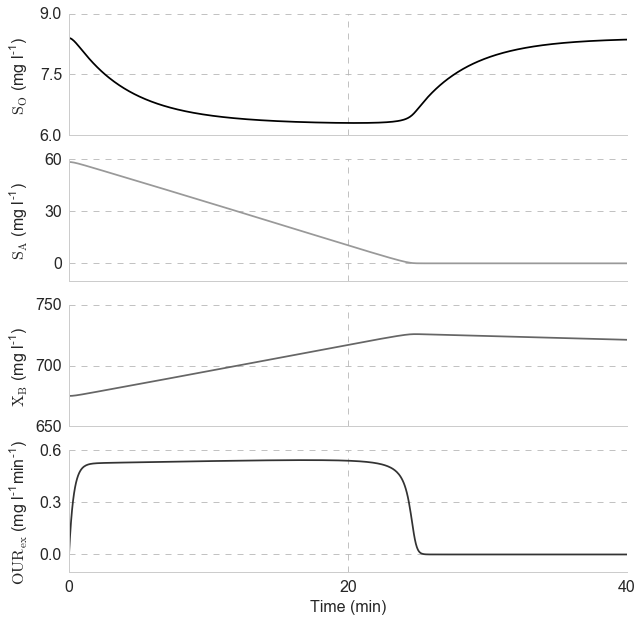

In [36]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(output.index*24*60., output["DO"], color ='0.') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_{\mathrm{O}}$ ($mg\ l^{-1}$)')
axs[0].set_yticks([6., 7.5, 9.])

axs[1].plot(output.index*24*60., output["S"],'-', color ='0.6')
axs[1].set_ylabel(r'$\mathrm{S}_{\mathrm{A}}$ ($mg\ l^{-1}$)')
axs[1].set_yticks([0., 30., 60.])

axs[2].plot(output.index*24*60., output["X"],'-', color ='0.4')
axs[2].set_ylabel(r'$\mathrm{X}_{\mathrm{B}}$ ($mg\ l^{-1}$)')
axs[2].set_yticks([650, 700, 750])

axs[3].plot(output.index*24*60., output["OURex"],'-', color ='0.2')
axs[3].set_ylabel(r'$\mathrm{OUR}_{\mathrm{ex}}$ ($mg\ l^{-1} min^{-1}$)')
axs[3].set_yticks([0,0.3, 0.6])
axs[3].set_xlim([0, 40])
axs[3].set_xticks([0, 20, 40.])
axs[3].set_xlabel('Time (min)')


labelx = -0.07
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_output.png', dpi=300)
plt.savefig('respiro_output.pdf', dpi=300)

In [52]:
respiro_ref_sens = NumericalLocalSensitivity(respiro_model)
ref_cprs = respiro_ref_sens.get_sensitivity(method='CPRS')

In [53]:
perc_max = 0.9
high_mumax = ref_cprs["DO"]["mumax"][ref_cprs ["DO"]["mumax"].abs() > ref_cprs ["DO"]["mumax"].abs().quantile(perc_max)]
mumax_split = np.where(high_mumax.reset_index().diff()['index'].values > 1)[0][0]
high_ks = ref_cprs["DO"]["ks"][ref_cprs["DO"]["ks"].abs() > ref_cprs["DO"]["ks"].abs().quantile(perc_max)]
ks_split = np.where(high_ks.reset_index().diff()['index'].values > 1)[0][0]
ks_split2 = np.where(high_ks.reset_index().diff()['index'].values > 1)[0][1]

high_tau=ref_cprs ["DO"]["tau"][ref_cprs["DO"]["tau"].abs() > ref_cprs ["DO"]["tau"].abs().quantile(perc_max)]
tau_split = np.where(high_tau.reset_index().diff()['index'].values > 1)[0][0]
tau_split2 = np.where(high_tau.reset_index().diff()['index'].values > 1)[0][1]

In [56]:
ref_cprs.index = timestepping*24*60.

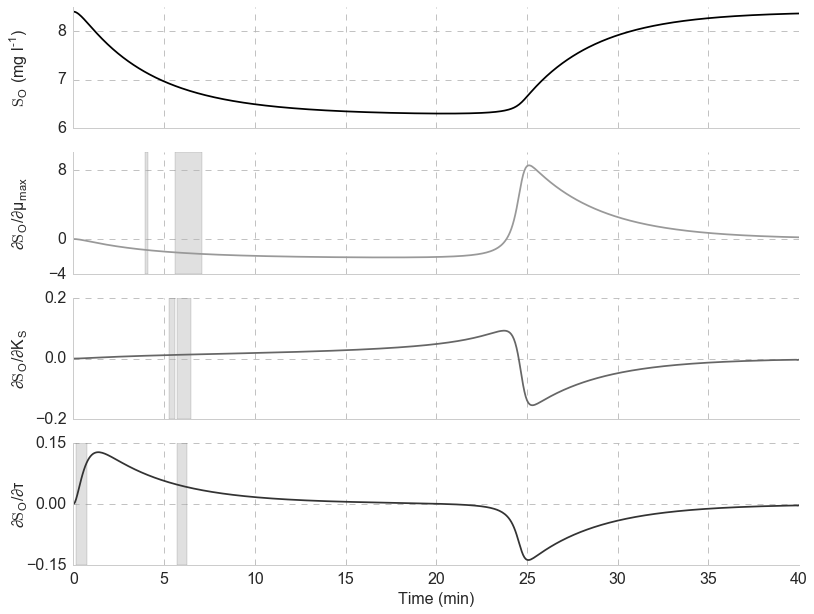

In [61]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(output.index*24*60., output["DO"], color ='0.', 
            label ='$\mathrm{S}_{O}$') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_O$ ($mg\ l^{-1}$)')
axs[0].set_yticks([6., 7., 8.])

axs[1].plot(ref_cprs.index, ref_cprs["DO"]["mumax"],'-', color ='0.6')
axs[1].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial \mu_{max}$')
axs[1].axvspan(high_mumax.index[0]/60., high_mumax.index[mumax_split-1]/60., facecolor='0.7', alpha=0.4)
axs[1].axvspan((high_mumax.index[mumax_split])/60., high_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[1].set_yticks([-4., 0, 8.])

axs[2].plot(ref_cprs.index, ref_cprs["DO"]["ks"],'-', color ='0.4')
axs[2].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial K_{S}}$')
axs[2].axvspan(high_ks.index[0]/60., high_ks.index[ks_split-1]/60., facecolor='0.7', alpha=0.4)
axs[2].axvspan((high_ks.index[ks_split])/60., high_ks.index[ks_split2-1]/60., facecolor='0.7', alpha=0.4)
#axs[2].axvspan(high_ks.index[0]/60., high_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].set_yticks([-.2, 0, 0.2])

axs[3].plot(ref_cprs.index, ref_cprs["DO"]["tau"],'-', color ='0.2')
axs[3].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial {\tau}}$')
axs[3].axvspan(high_tau.index[0]/60., high_tau.index[tau_split-1]/60., facecolor='0.7', alpha=0.4)
axs[3].axvspan((high_tau.index[tau_split])/60., high_tau.index[tau_split2-1]/60., facecolor='0.7', alpha=0.4)
#axs[3].axvspan(high_tau.index[0]/60., high_tau.index[-1]/60., facecolor='0.5', alpha=0.4)
axs[3].set_yticks([-.15, 0, 0.15])
#axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xlabel('Time (min)')
axs[3].set_xlim([0, 40])


labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_ref.png', dpi=300)
plt.savefig('respiro_ref.pdf', dpi=300)

## High ratio implementation thesis Stijn DC

In [21]:
###constanten
#####################
m = 0.998224877
C = 64.0
n = 0.942226016
x = 2.
bc = -0.00023307
bh = 0.24
Y = 0.70
p = 0.982527909
ixb = 0.086

Y = 0.70
bh = 0.24
kla = 0.007
A = (m/(C*Y))
B = n*(1-Y)*x/(C*Y)
C = p*ixb/14
D = 0 #geen endogene respiratie want zit samen in bc!
DOi  = 8.91

In [22]:
parameters = {'ks':  1.60, 'tau':77.6 ,'mumax':3.78}
system = {'dSS':'-(1.-exp(-(t/tau)))*(mumax/(3600*24))*XX/('+str(Y)+')*SS/((SS+ks))',
          'dDO':'('+str(kla)+'*('+str(DOi)+' - DO)-(1.-exp(-(t/tau)))*(mumax/(3600*24))*(XX/('+str(Y)+'))*(1-'+str(Y)+')*SS/((SS+ks)))',
          'dXX' :'(1.-exp(-(t/tau)))*(mumax*XX/(3600*24))*SS/(SS+ks)-('+str(bh)+'/(24*3600))*XX'}

In [23]:
timestepping = np.linspace(0, 2400, 2400)
respiro_high = Model('Respirometry', system, parameters)
respiro_high.set_independent({'t': timestepping})
respiro_high.set_initial({'SS':69, 'DO':DOi, 'XX':835})
respiro_high.initialize_model()

In [24]:
69/835.

0.08263473053892216

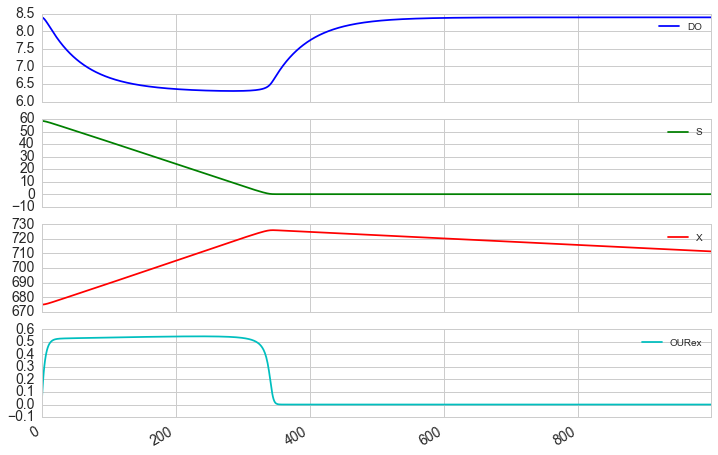

In [25]:
output_high = respiro_high.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output_high.index = timestepping

In [26]:
respiro_high_sens = NumericalLocalSensitivity(respiro_high)
high_cprs = respiro_high_sens.get_sensitivity(method='CPRS')

In [27]:
perc_max = 0.9
high_mumax = high_cprs["DO"]["mumax"][high_cprs["DO"]["mumax"].abs() > high_cprs["DO"]["mumax"].abs().quantile(perc_max)]
high_ks = high_cprs["DO"]["ks"][high_cprs["DO"]["ks"].abs() > high_cprs["DO"]["ks"].abs().quantile(perc_max)]
#ks_split = np.where(high_ks.reset_index().diff()['index'].values > 1)[0][0]
high_tau=high_cprs["DO"]["tau"][high_cprs["DO"]["tau"].abs() > high_cprs["DO"]["tau"].abs().quantile(perc_max)]
tau_split = np.where(high_tau.reset_index().diff()['index'].values > 1)[0][0]

In [28]:
np.where(high_ks.reset_index().diff()['index'].values > 1)[0]

array([], dtype=int64)

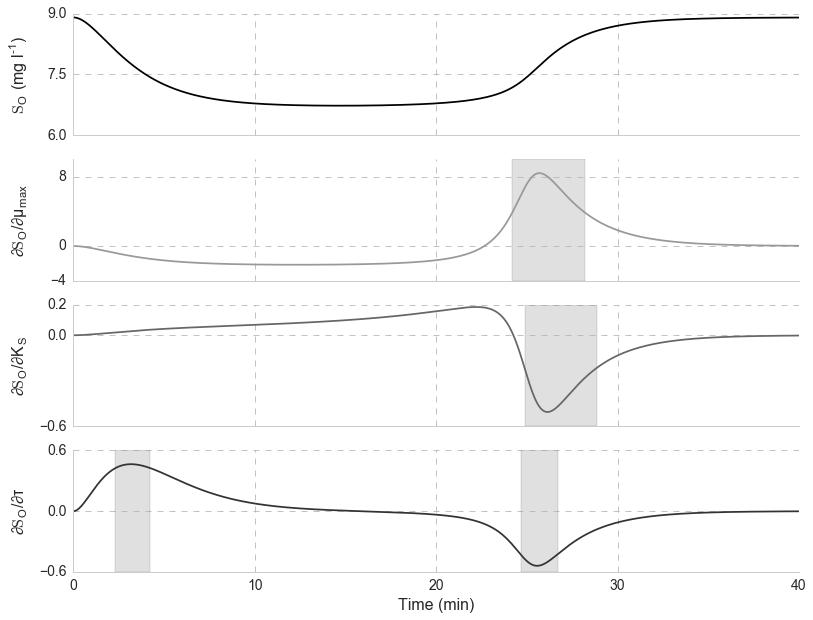

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(high_cprs.index/60., output_high["DO"], color ='0.', 
            label ='$\mathrm{S}_{O}$') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_O$ ($mg\ l^{-1}$)')
axs[0].set_yticks([6., 7.5, 9.])

axs[1].plot(high_cprs.index/60., high_cprs["DO"]["mumax"],'-', color ='0.6')
axs[1].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial \mu_{max}$')
axs[1].axvspan(high_mumax.index[0]/60., high_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[1].set_yticks([-4., 0, 8.])

axs[2].plot(high_cprs.index/60., high_cprs["DO"]["ks"],'-', color ='0.4')
axs[2].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial K_{S}}$')
#axs[2].axvspan(high_ks.index[0]/60., high_ks.index[ks_split-1]/60., facecolor='0.7', alpha=0.4)
#axs[2].axvspan((high_ks.index[ks_split])/60., high_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].axvspan(high_ks.index[0]/60., high_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].set_yticks([-.6, 0, 0.2])

axs[3].plot(high_cprs.index/60., high_cprs["DO"]["tau"],'-', color ='0.2')
axs[3].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial {\tau}}$')
axs[3].axvspan(high_tau.index[0]/60., high_tau.index[tau_split-1]/60., facecolor='0.7', alpha=0.4)
axs[3].axvspan((high_tau.index[tau_split])/60., high_tau.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[3].axvspan(high_tau.index[0]/60., high_tau.index[-1]/60., facecolor='0.5', alpha=0.4)
axs[3].set_yticks([-.6, 0, 0.6])
axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xlabel('Time (min)')


labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_highratio.png', dpi=600)
plt.savefig('respiro_highratio.pdf', dpi=600)

## Low ratio implementation thesis Stijn DC

In [30]:
####constanten
#m = 0.998224877
C = 64.0
n = 0.942226016
x = 2.
bc = -0.00023307
bh = 0.24
Y = 0.73
p = 0.982527909
ixb = 0.086

Y = 0.73
bh = 0.24
kla = 0.007
A = (m/(C*Y))
B = n*(1-Y)*x/(C*Y)
C = p*ixb/14
D = 0 #geen endogene respiratie want zit samen in bc!
DOi  = 8.94

In [31]:
Modelname = 'Respiromodel_low'

In [32]:
initcond = {'S':12.25, 'DO':DOi, 'X':835}
parameters = {'ks':  3.17, 'tau':155 ,'mumax':7.44}
system = {'dSS':'-(1.-exp(-(t/tau)))*(mumax/(3600*24))*XX/('+str(Y)+')*SS/((SS+ks))',
          'dDO':'('+str(kla)+'*('+str(DOi)+' - DO)-(1.-exp(-(t/tau)))*(mumax/(3600*24))*(XX/('+str(Y)+'))*(1-'+str(Y)+')*SS/((SS+ks)))',
          'dXX' :'(1.-exp(-(t/tau)))*(mumax*XX/(3600*24))*SS/(SS+ks)-('+str(bh)+'/(24*3600))*XX'}

In [33]:
timestepping = np.linspace(0, 2400, 2400)
respiro_low = Model('Respirometry', system, parameters)
respiro_low.set_independent({'t': timestepping})
respiro_low.set_initial({'SS':17.25, 'DO':DOi, 'XX':835})
respiro_low.initialize_model()

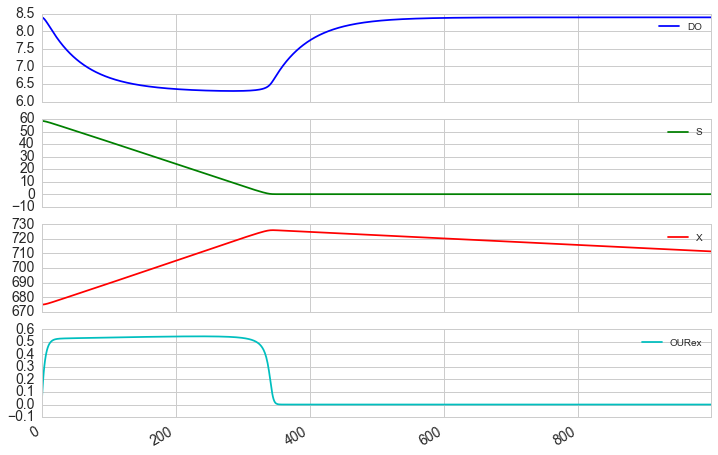

In [34]:
output_low = respiro_low.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output_low.index = timestepping

In [35]:
respiro_low_sens = NumericalLocalSensitivity(respiro_low)
low_cprs = respiro_low_sens.get_sensitivity(method='CPRS')

In [36]:
#perc_max = 0.9
low_mumax = low_cprs["DO"]["mumax"][low_cprs["DO"]["mumax"].abs() > low_cprs["DO"]["mumax"].abs().quantile(perc_max)]
mumax_split = np.where(low_mumax.reset_index().diff()['index'].values > 1)[0][0]
low_ks = low_cprs["DO"]["ks"][low_cprs["DO"]["ks"].abs() > low_cprs["DO"]["ks"].abs().quantile(perc_max)]
ks_split = np.where(low_ks.reset_index().diff()['index'].values > 1)[0][0]
low_tau=low_cprs["DO"]["tau"][low_cprs["DO"]["tau"].abs() > low_cprs["DO"]["tau"].abs().quantile(perc_max)]
tau_split = np.where(low_tau.reset_index().diff()['index'].values > 1)[0][0]

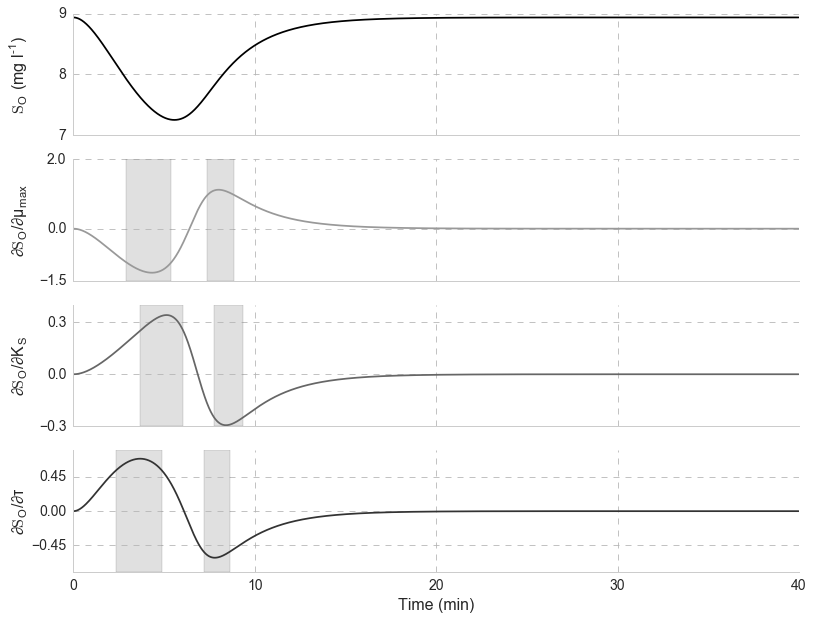

In [37]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(low_cprs.index/60., output_low["DO"], color ='0.', 
            label ='$\mathrm{S_{O}}$') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_O$ ($mg\ l^{-1}$)')
axs[0].set_yticks([7., 8., 9.])

axs[1].plot(low_cprs.index/60., low_cprs["DO"]["mumax"],'-', color ='0.6')
axs[1].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial \mu_{max}$')
axs[1].axvspan(low_mumax.index[0]/60., low_mumax.index[mumax_split-1]/60., facecolor='0.7', alpha=0.4)
axs[1].axvspan((low_mumax.index[mumax_split])/60., low_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[1].axvspan(low_mumax.index[0]/60.,low_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[1].set_yticks([-1.5, 0, 2.])

axs[2].plot(low_cprs.index/60., low_cprs["DO"]["ks"],'-', color ='0.4')
axs[2].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial K_{S}}$')
axs[2].axvspan(low_ks.index[0]/60., low_ks.index[ks_split-1]/60., facecolor='0.7', alpha=0.4)
axs[2].axvspan((low_ks.index[ks_split])/60., low_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[2].axvspan(low_ks.index[0]/60., low_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].set_yticks([-0.3, 0, 0.3])

axs[3].plot(low_cprs.index/60., low_cprs["DO"]["tau"],'-', color ='0.2')
axs[3].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial {\tau}}$')
axs[3].axvspan(low_tau.index[0]/60., low_tau.index[tau_split-1]/60., facecolor='0.7', alpha=0.4)
axs[3].axvspan((low_tau.index[tau_split])/60., low_tau.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[3].axvspan(high_tau.index[0]/60., high_tau.index[-1]/60., facecolor='0.5', alpha=0.4)
axs[3].set_yticks([-.45, 0, 0.45])
axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xlabel('Time (min)')

labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_lowratio.png', dpi=600)
plt.savefig('respiro_lowratio.pdf', dpi=600)

### SOBOL

#### refcase

grenzen van Cierkens2012

In [ ]:
# cierkens2012 pur sang
#Xref = [(0.41*0.8, 0.41*1.2,'ks'),(0.000226*0.5, 0.000226*1.5,'tau'),(4.*0.8, 4*1.2,'mumax'), (60*0.5, 60.*1.5, 'Sinit')]

In [362]:
Xref = [(0.41*0.8, 0.41*1.2,'ks'),(0.000226*0.5, 0.001*1.5,'tau'),(4.*0.8, 4*1.2,'mumax'), (60*0.5, 60.*1.5, 'Sinit')]

In [363]:
ref_sobol = pyst.SobolVariance(Xref, ModelType='external')
ref_sobol.SobolVariancePre(3000, seed=1)

The analysed model is externally run
1
The total cost of the analysis well be 18000 Monte Carlo Runs
(3000, 8)
(18000, 4)
The parameter sets to calculate the model are stored in self.parset2run and can be extracted


In [383]:
ref_sobol.parset2run

array([[  4.10000000e-01,   8.06500000e-04,   4.00000000e+00,
          6.00000000e+01],
       [  4.51000000e-01,   4.59750000e-04,   4.40000000e+00,
          4.50000000e+01],
       [  3.69000000e-01,   1.15325000e-03,   3.60000000e+00,
          7.50000000e+01],
       ..., 
       [  4.44874023e-01,   3.21930420e-04,   4.09414062e+00,
          4.17919922e+01],
       [  3.62874023e-01,   1.01543042e-03,   3.29414063e+00,
          7.17919922e+01],
       [  3.52624023e-01,   5.81992920e-04,   4.39414063e+00,
          3.80419922e+01]])

In [364]:
outputs_ref = np.zeros((ref_sobol.parset2run.shape[0], 1000))
for i in range(ref_sobol.parset2run.shape[0]):
    respiro_model.set_parameter('ks', ref_sobol.parset2run[i, 0])
    respiro_model.set_parameter('tau', ref_sobol.parset2run[i, 1])
    respiro_model.set_parameter('mumax', ref_sobol.parset2run[i, 2])
    respiro_model.set_initial({'S': ref_sobol.parset2run[i, 3], 'X': 675, 'DO':8.4})
    outputs_ref[i,:] = respiro_model.run()['DO']

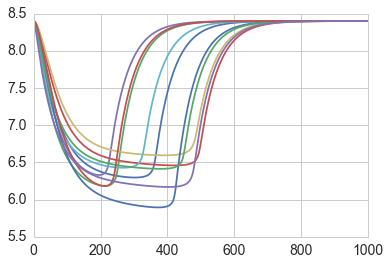

In [365]:
for i in range(10):
    plt.plot(outputs_ref[i,:])

In [413]:
ref_df = pd.DataFrame(outputs_ref.transpose(), index=pd.date_range(start='20150101', periods=1000, freq='S'))
ref_df.columns = [str(col) for col in ref_df.columns]

In [367]:
ref_hp = hp.HydroAnalysis(ref_df)

In [368]:
ref_minute = ref_hp.frequency_resample('1Min', 'mean')

In [369]:
ref_si_vals = {}
ref_sti_vals = {}
for idx, row in ref_minute.data.iterrows():
    si, sti, stij = ref_sobol.SobolVariancePost(row.values[:-1])
    ref_si_vals[idx] = si.flatten()
    ref_sti_vals[idx] = sti.flatten()
    

In [435]:
ref_sis = pd.DataFrame(ref_si_vals.values(), index=ref_si_vals.keys(), columns=['ks','tau', 'mumax', 'Sinit'])
ref_sis = ref_sis.sort_index()

In [436]:
ref_stis = pd.DataFrame(ref_sti_vals.values(), index=ref_sti_vals.keys(), columns=['ks','tau', 'mumax', 'Sinit'])
ref_stis = ref_stis.sort_index()

In [437]:
ref_sis['som'] = ref_sis.sum(axis=1)
ref_stis['som'] = ref_stis.sum(axis=1)

In [451]:
ref_sis

,ks,tau,mumax,Sinit,som
1,-0.000168,0.802869,0.236292,-0.001436,1.037557
2,-0.000197,0.281530,0.734252,-0.001520,1.014065
3,-0.000902,0.041831,0.957183,-0.008462,0.989650
4,0.000152,0.002514,0.517378,0.169354,0.689398
5,-0.000049,0.006178,0.031571,0.757930,0.795630
6,-0.000438,-0.004923,-0.006028,0.873165,0.861776
7,-0.000114,0.011180,0.019111,0.892468,0.922645
8,0.000234,-0.000872,0.075428,0.846905,0.921695
9,-0.000636,0.003022,0.135653,0.709809,0.847848
10,0.003448,0.013630,0.149363,0.571663,0.738103


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f16343dba50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1603f59650>], dtype=object)

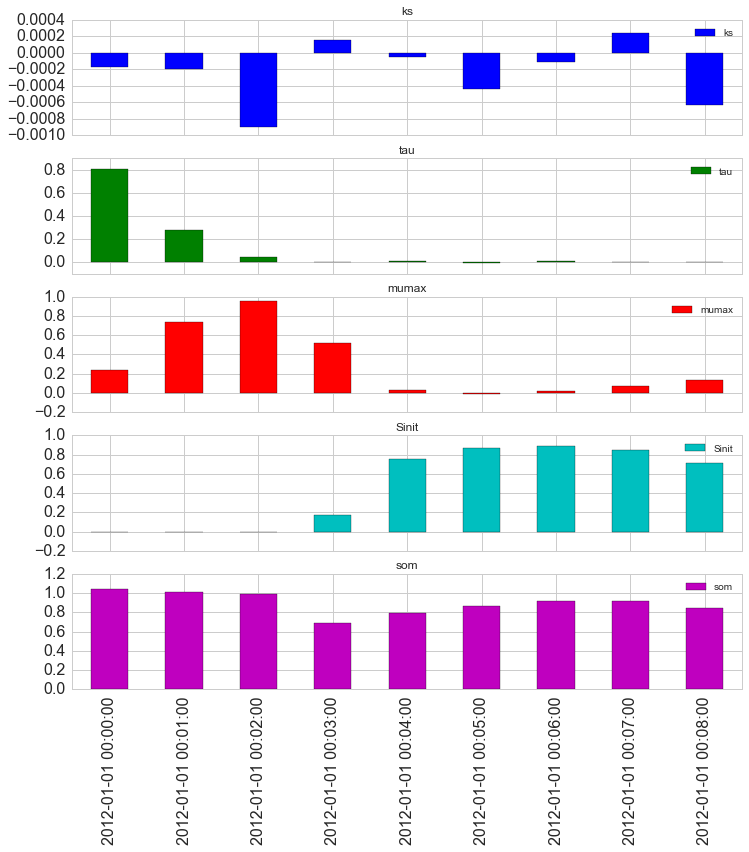

In [439]:
ref_sis.iloc[:9].plot(subplots=True, figsize=(12, 12), kind='bar')

In [460]:
ref_sis.index = np.arange(1, 18, 1)

In [461]:
ref_sis_plot = ref_sis[:10].copy()

In [493]:
ref_stis.index = np.arange(1, 18, 1)
ref_stis_plot = ref_stis[:10].copy()

In [464]:
ref_sis_plot['ks'].loc[ref_sis_plot['ks'] < 0] = 0.0

In [1]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].bar(ref_sis_plot.index-0.75, ref_sis_plot['ks'].values, 
           color ='0.6', width=0.5) #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$K_S$', size=20)
axs[0].set_yticks([0.0, 0.002, 0.004])

axs[1].bar(ref_sis_plot.index-0.75, ref_sis_plot['tau'].values, color ='0.4', width=0.5) #, High $S_{}^0/X_{0}$
axs[1].set_ylabel(r'$\tau$', size=20)
axs[1].set_yticks([0.0, 0.5, 1.])
axs[1].set_ylim([0.0, 1.])

axs[2].bar(ref_sis_plot.index-0.75, ref_sis_plot['mumax'].values, color ='0.6', width=0.5) #, High $S_{}^0/X_{0}$
axs[2].set_ylabel(r'$\mu_{max}$', size=20)
axs[2].set_yticks([0.0, 0.5, 1.])
axs[2].set_ylim([0.0, 1.])

axs[3].bar(ref_sis_plot.index-0.75, ref_sis_plot['Sinit'].values, color ='0.4', width=0.5) #, High $S_{}^0/X_{0}$
axs[3].set_ylabel(r'$S_A^0$', size=20)
axs[3].set_yticks([0.0, 0.5, 1.])
axs[3].set_ylim([0.0, 1.])
axs[3].set_xticks(np.arange(1, 10, 1))
axs[3].set_xlabel('Time (min)')

labelx = -0.07
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('sobol_minute.png', dpi=600)
plt.savefig('sobol_minute.pdf', dpi=600)


NameError: name 'ref_sis_plot' is not defined

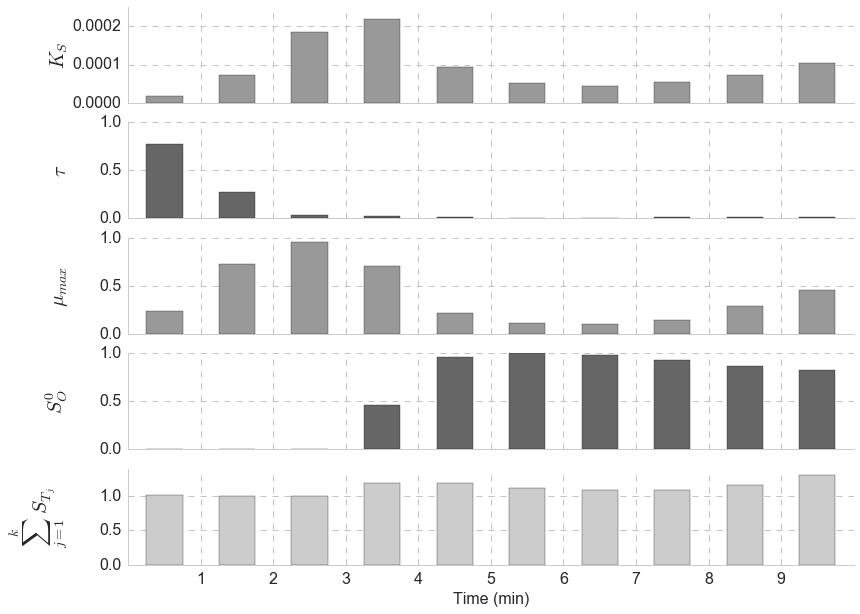

In [499]:
fig, axs = plt.subplots(5, 1, figsize=(13, 10), sharex=True)

axs[0].bar(ref_stis_plot.index-0.75, ref_stis_plot['ks'].values, 
           color ='0.6', width=0.5) #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$K_S$', size=20)
axs[0].set_yticks([0.0, 0.0001, 0.0002])

axs[1].bar(ref_stis_plot.index-0.75, ref_stis_plot['tau'].values, color ='0.4', width=0.5) #, High $S_{}^0/X_{0}$
axs[1].set_ylabel(r'$\tau$', size=20)
axs[1].set_yticks([0.0, 0.5, 1.])
#axs[1].set_ylim([0.0, 1.])

axs[2].bar(ref_stis_plot.index-0.75, ref_stis_plot['mumax'].values, color ='0.6', width=0.5) #, High $S_{}^0/X_{0}$
axs[2].set_ylabel(r'$\mu_{max}$', size=20)
axs[2].set_yticks([0.0, 0.5, 1.])
#axs[2].set_ylim([0.0, 1.])

axs[3].bar(ref_stis_plot.index-0.75, ref_stis_plot['Sinit'].values, color ='0.4', width=0.5) #, High $S_{}^0/X_{0}$
axs[3].set_ylabel(r'$S_A^0$', size=20)
axs[3].set_yticks([0.0, 0.5, 1.])
#axs[3].set_ylim([0.0, 1.])

axs[4].bar(ref_stis_plot.index-0.75, ref_stis_plot['som'].values, color ='0.8', width=0.5) #, High $S_{}^0/X_{0}$
axs[4].set_ylabel(r'$\sum_{j=1}^{k}\ S_{T_j}$', size=20)
axs[4].set_yticks([0.0, 0.5, 1.])
#axs[3].set_ylim([0.0, 1.])
axs[4].set_xticks(np.arange(1, 10, 1))
axs[4].set_xlabel('Time (min)')

labelx = -0.08
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('sobol_minute_st.png', dpi=600)
plt.savefig('sobol_minute_st.pdf', dpi=600)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1603853fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1603649110>], dtype=object)

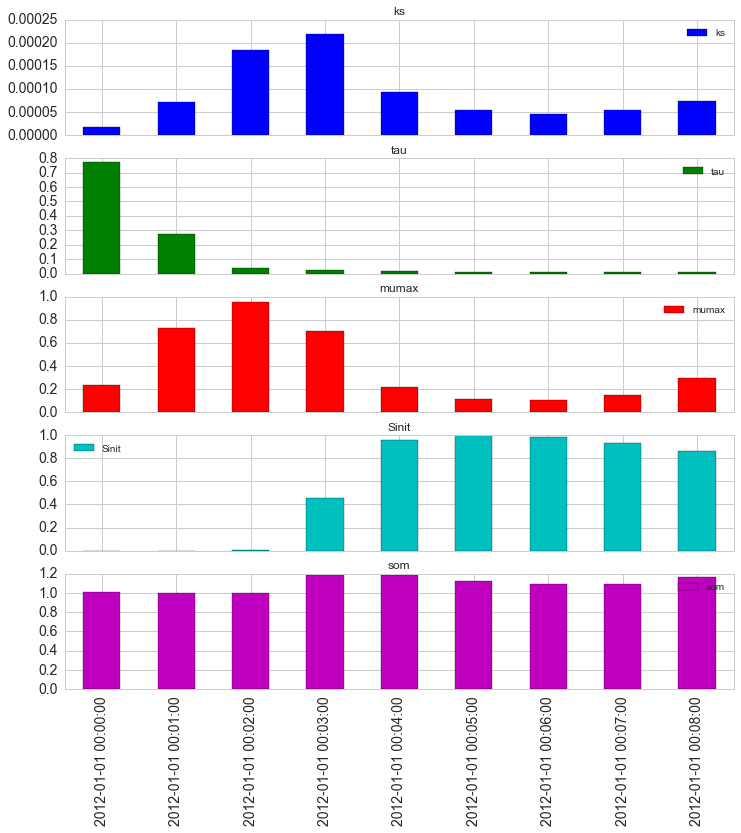

In [375]:
ref_stis.iloc[:9].plot(subplots=True, figsize=(12, 12), kind='bar')

In [517]:
si, sti, stij = ref_sobol.SobolVariancePost(outputs_ref.mean(axis=1))

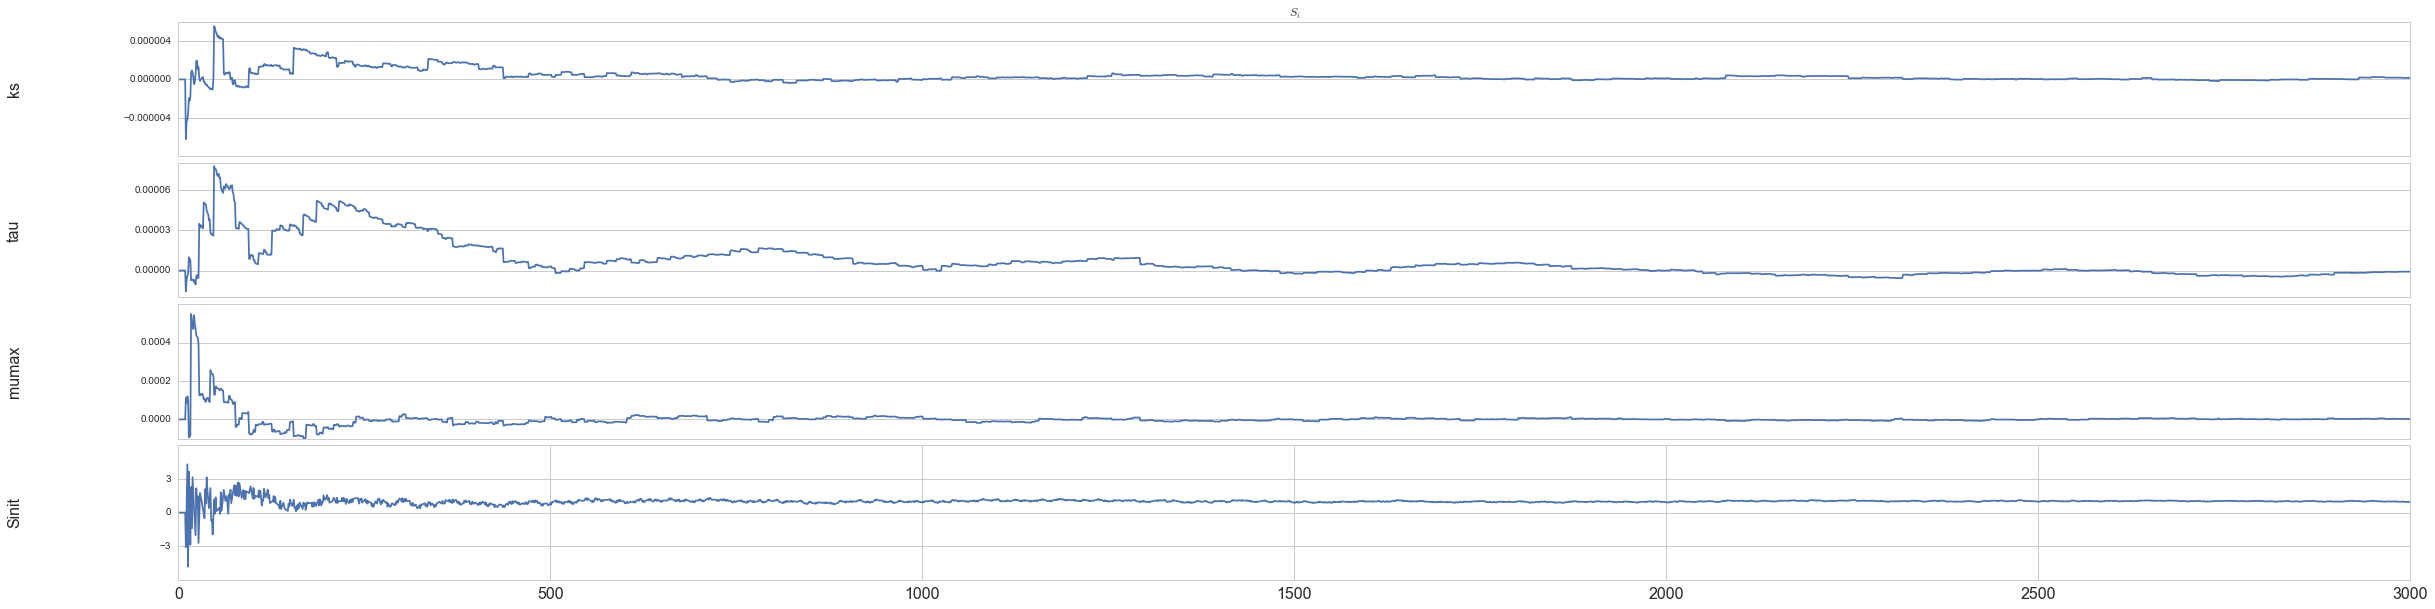

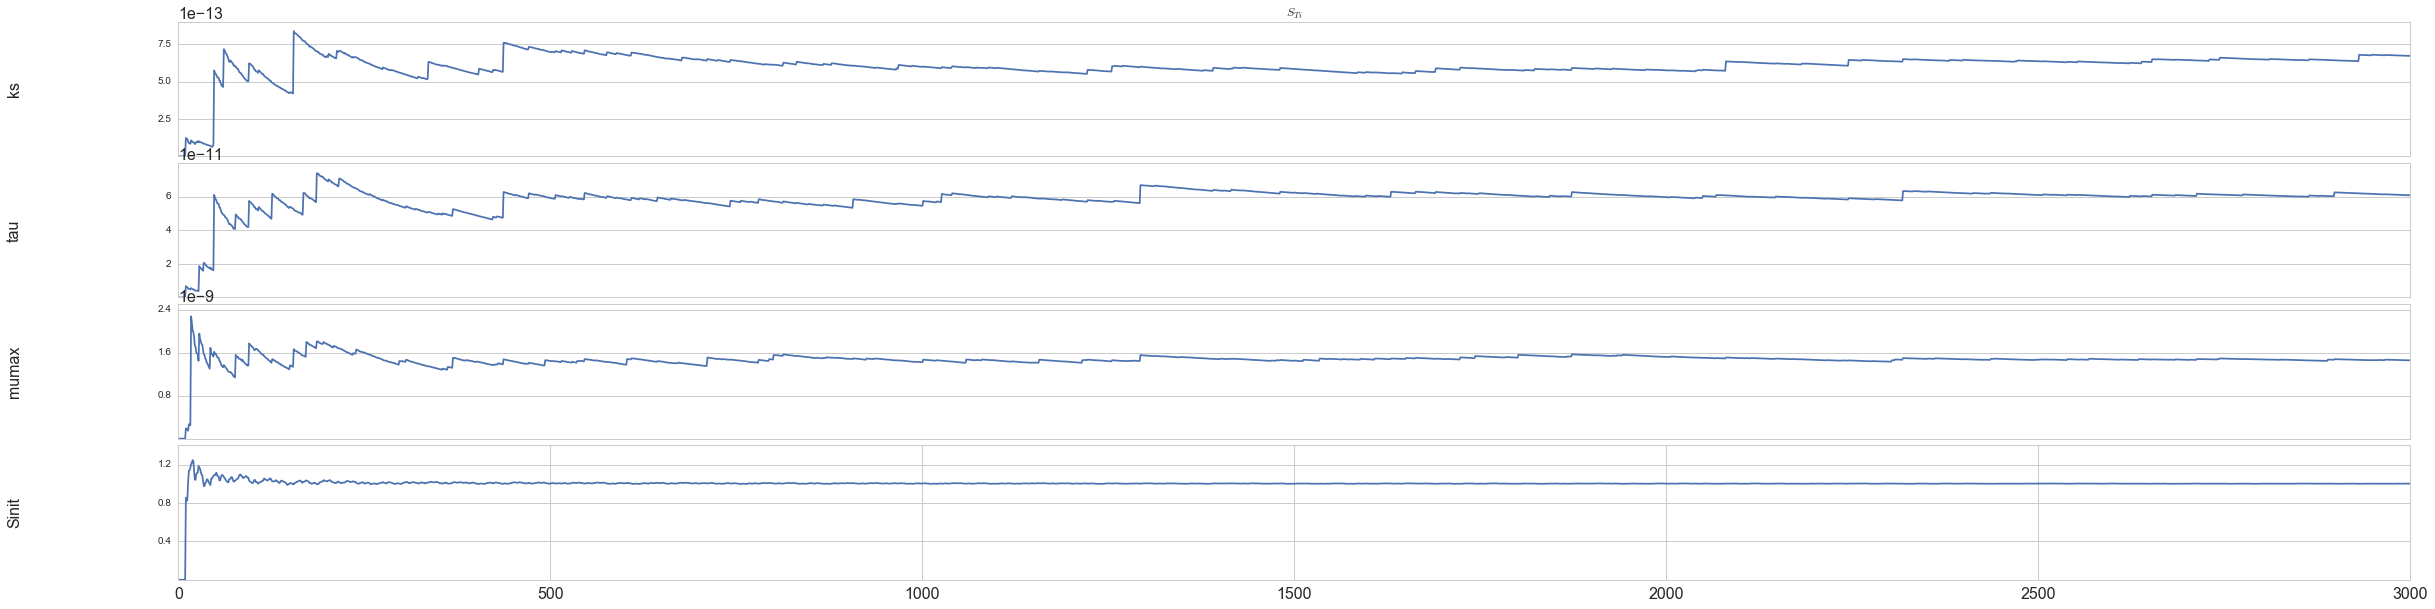

In [518]:
Si_evol, STi_evol = ref_sobol.sens_evolution()

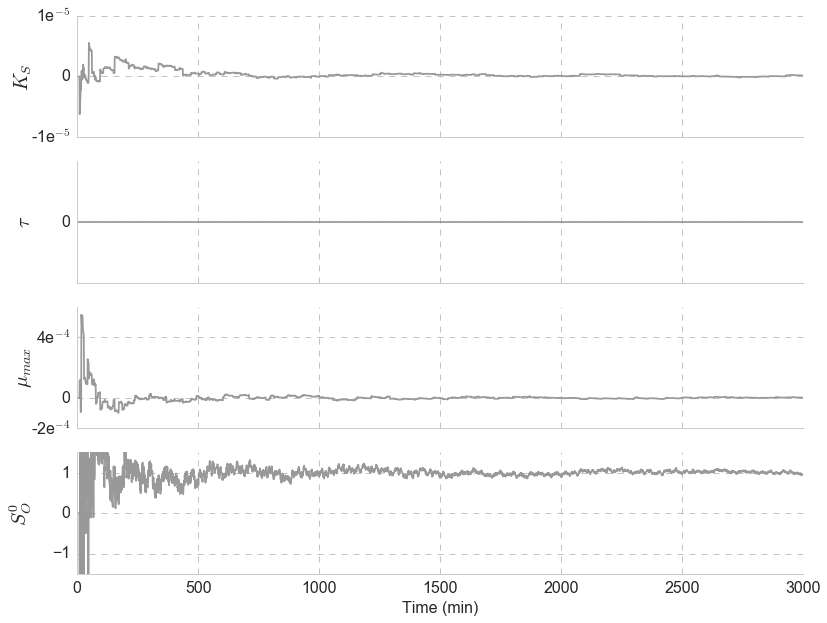

In [530]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(Si_evol[:,0], color ='0.6')
axs[0].set_ylabel('$K_S$', size=20)
axs[0].set_yticks([-0.00001, 0., 0.00001])
axs[0].set_yticklabels(['-1e$^{-5}$','0', '1e$^{-5}$'])

axs[1].plot(Si_evol[:,1], color ='0.6')
axs[1].set_ylabel(r'$\tau$', size=20)
axs[1].set_yticks([0.0, 2., 4.])
axs[1].set_ylim([-0.5, 0.5])

axs[2].plot(Si_evol[:,2], color ='0.6')
axs[2].set_ylabel(r'$\mu_{max}$', size=20)
axs[2].set_yticks([-0.0002, 0.0, 0.0004])
axs[2].set_yticklabels(['-2e$^{-4}$','0', '4e$^{-4}$'])

axs[3].plot(Si_evol[:,3], color ='0.6')
axs[3].set_ylabel(r"$S_{A}^{0}$", size=20)
axs[3].set_yticks([-1.,0.0,1.])
axs[3].set_ylim([-1.5, 1.5])
axs[3].set_xlabel('Time (min)')

labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('sensevols.png', dpi=300)
plt.savefig('sensevols.pdf', dpi=300)

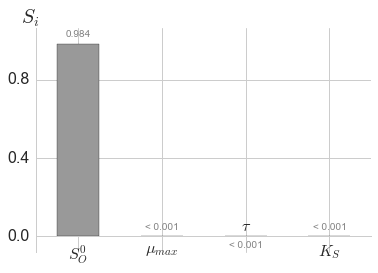

In [411]:
fig, ax = ref_sobol.plotSi(color='0.6')
ax.set_xticklabels([r"$S_{A}^{0}$",r"$\mu_{max}$",r"$\tau$",r"$K_S$"])
fig.savefig('sobol_mean_si.pdf')
fig.savefig('sobol_mean_si.png')

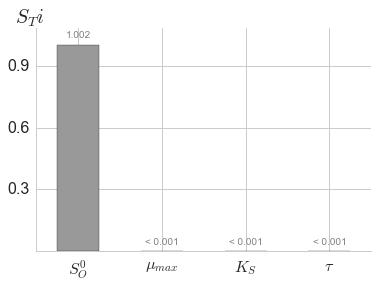

In [412]:
fig, ax = ref_sobol.plotSTi(color='0.6')
ax.set_xticklabels([r"$S_{A}^{0}$", r"$\mu_{max}$", r"$K_S$", r"$\tau$"])
fig.savefig('sobol_mean_sti.pdf')
fig.savefig('sobol_mean_sti.png')

In [397]:
import pylab as p
p.rc('mathtext', default='it')

#### high ratio

high: parameters = {'ks':  1.60, 'tau':77.6 ,'mumax':3.78}
low: parameters = {'ks':  3.17, 'tau':155 ,'mumax':7.44}

In [38]:
Xi = [(0.5, 5.5,'ks'),(50., 250.,'tau'),(2., 8.,'mumax')]

In [39]:
respiro_sobol = pyst.SobolVariance(Xi, ModelType='external')
respiro_sobol.SobolVariancePre(2000, seed=1)

The analysed model is externally run
1
The total cost of the analysis well be 10000 Monte Carlo Runs
(2000, 6)
(10000, 3)
The parameter sets to calculate the model are stored in self.parset2run and can be extracted


In [40]:
outputs_high = np.zeros((respiro_sobol.parset2run.shape[0], 2400))
for i in range(respiro_sobol.parset2run.shape[0]):
    respiro_high.set_parameter('ks', respiro_sobol.parset2run[i, 0])
    respiro_high.set_parameter('tau', respiro_sobol.parset2run[i, 1])
    respiro_high.set_parameter('mumax', respiro_sobol.parset2run[i, 2])
    respiro_high.set_initial()
    outputs_high[i,:] = respiro_high.run()['DO']

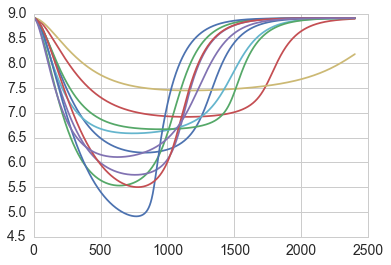

In [41]:
for i in range(10):
    plt.plot(outputs_high[i,:])

In [42]:
high_df = pd.DataFrame(outputs_high.transpose(), index=pd.date_range(start='20120101',periods=2400, freq='S'))
high_df.columns = [str(col) for col in high_df.columns]

In [43]:
high_hp = hp.HydroAnalysis(high_df)

In [141]:
high_minute = high_hp.frequency_resample('3Min', 'mean')

In [142]:
len(high_minute.data)

14

In [143]:
#high_sens = high_hp.get_recess().get_above_percentile(0.5)

In [144]:
#sval = [] 
#for i in range(10000):
#    sval.append(high_sens.data.iloc[:,i].dropna().min())

In [145]:
high_si_vals = {}
high_sti_vals = {}
for idx, row in high_minute.data.iterrows():
    si, sti, stij = respiro_sobol.SobolVariancePost(row.values[:-1])
    high_si_vals[idx] = si.flatten()
    high_sti_vals[idx] = sti.flatten()

In [146]:
high_sis = pd.DataFrame(high_si_vals.values(), index=high_si_vals.keys(), columns=['ks','tau', 'mumax'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f162ef80050>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f162ead0090>], dtype=object)

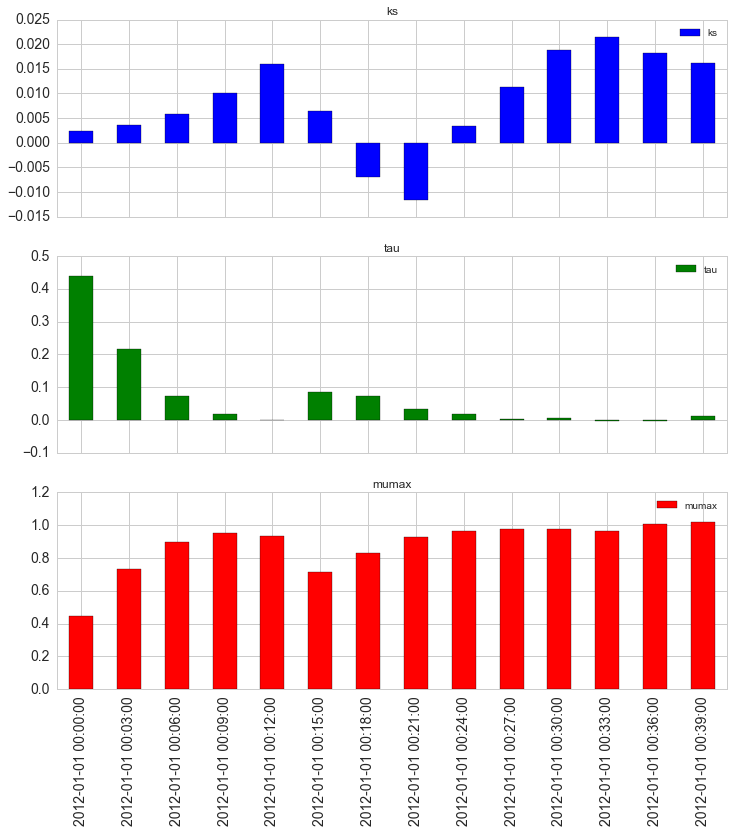

In [147]:
high_sis.sort_index().plot(subplots=True, figsize=(12, 12), kind='bar')

In [ ]:
for i in range(len(high_minute.data)):
    respiro_sobol.SobolVariancePost(np.array(sval))

In [ ]:
respiro_sobol.Si.sum()

In [ ]:
fig, ax = respiro_sobol.plotSi(color='0.6')
ax.set_xticklabels(['$\mu_{max}$',r"$\tau$",'$K_S$'])

In [ ]:
fig, ax = respiro_sobol.plotSTi(color='0.6')
ax.set_xticklabels(['$\mu_{max}$',r"$\tau$",'$K_S$'])

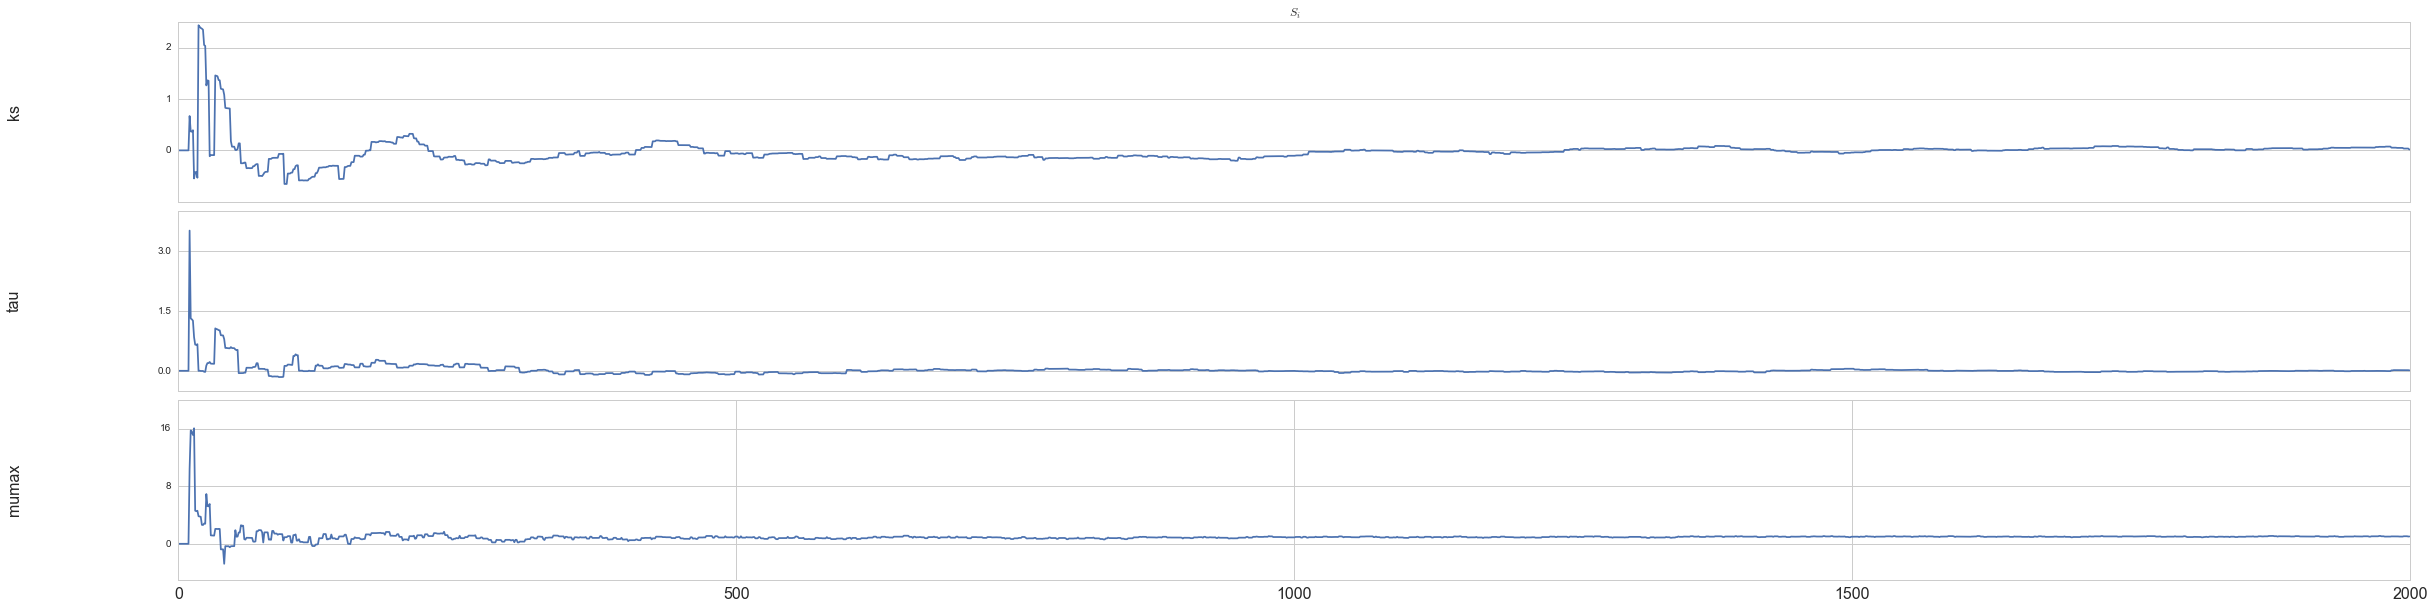

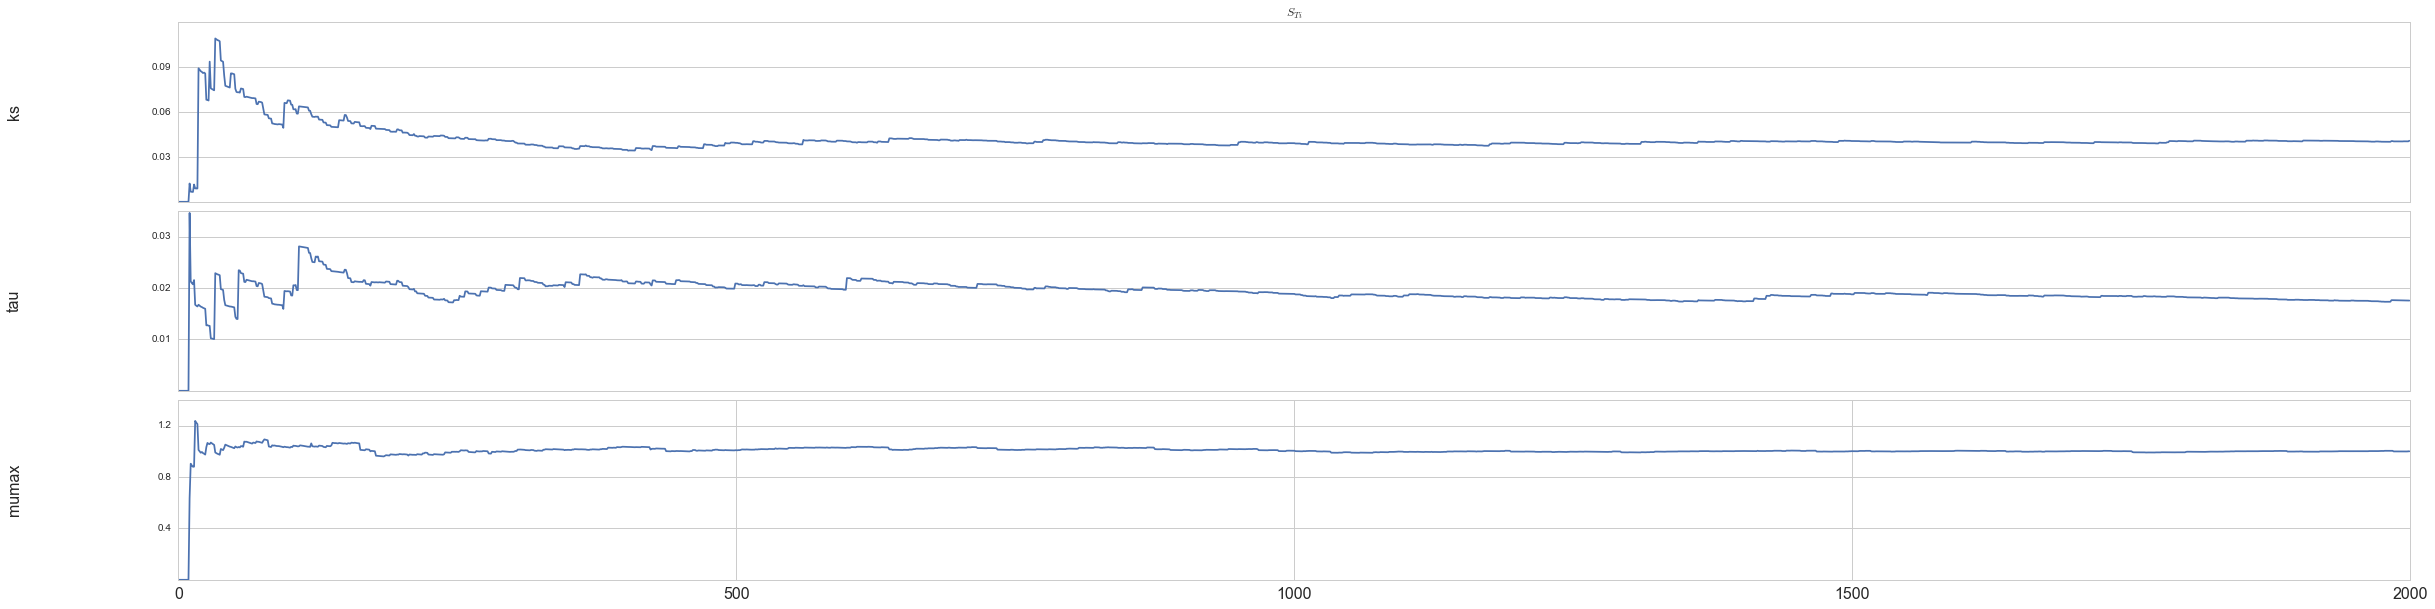

In [501]:
Si_evol, STi_evol = respiro_sobol.sens_evolution()

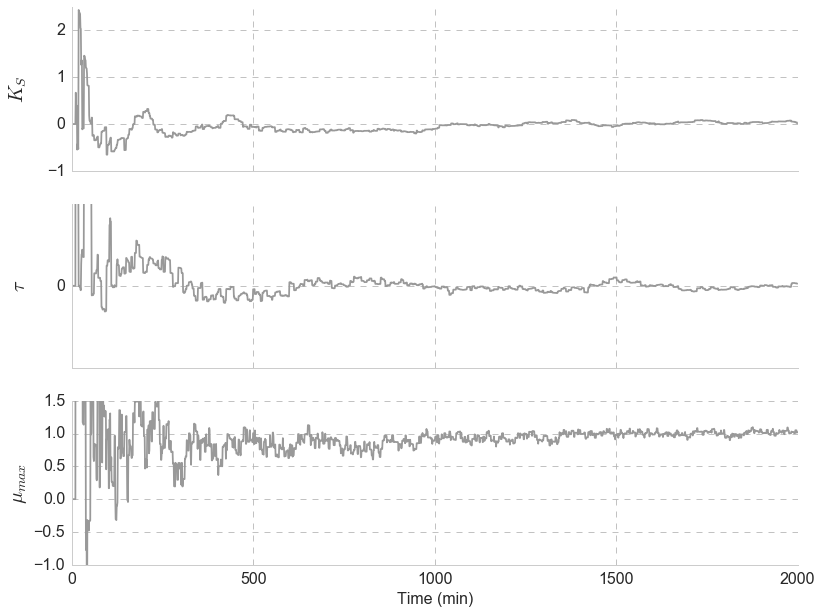

array([ 0.        ,  0.        ,  0.        , ...,  0.0355945 ,
        0.03558281,  0.01659192])

#### Low ratio

In [109]:
outputs_low = np.zeros((respiro_sobol.parset2run.shape[0], 2400))
for i in range(respiro_sobol.parset2run.shape[0]):
    respiro_low.set_parameter('ks', respiro_sobol.parset2run[i, 0])
    respiro_low.set_parameter('tau', respiro_sobol.parset2run[i, 1])
    respiro_low.set_parameter('mumax', respiro_sobol.parset2run[i, 2])
    outputs_low[i,:] = respiro_low.run()['DO']

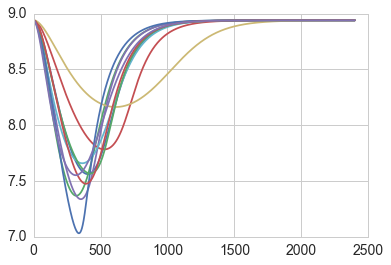

In [110]:
for i in range(10):
    plt.plot(outputs_low[i,:])

In [111]:
low_df = pd.DataFrame(outputs_low.transpose(), index=pd.date_range(start='20120101',periods=2400, freq='S'))
low_df.columns = [str(col) for col in low_df.columns]

In [112]:
low_hp = hp.HydroAnalysis(low_df)

In [128]:
low_minute = low_hp.frequency_resample('Min', 'min')

In [129]:
low_si_vals = {}
low_sti_vals = {}
for idx, row in low_minute.data.iterrows():
    si, sti, stij = respiro_sobol.SobolVariancePost(row.values[:-1])
    low_si_vals[idx] = si.flatten()
    low_sti_vals[idx] = sti.flatten()

In [130]:
low_sis = pd.DataFrame(low_si_vals.values(), index=low_si_vals.keys(), columns=['ks','tau', 'mumax'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1604e97b50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1604ccc6d0>], dtype=object)

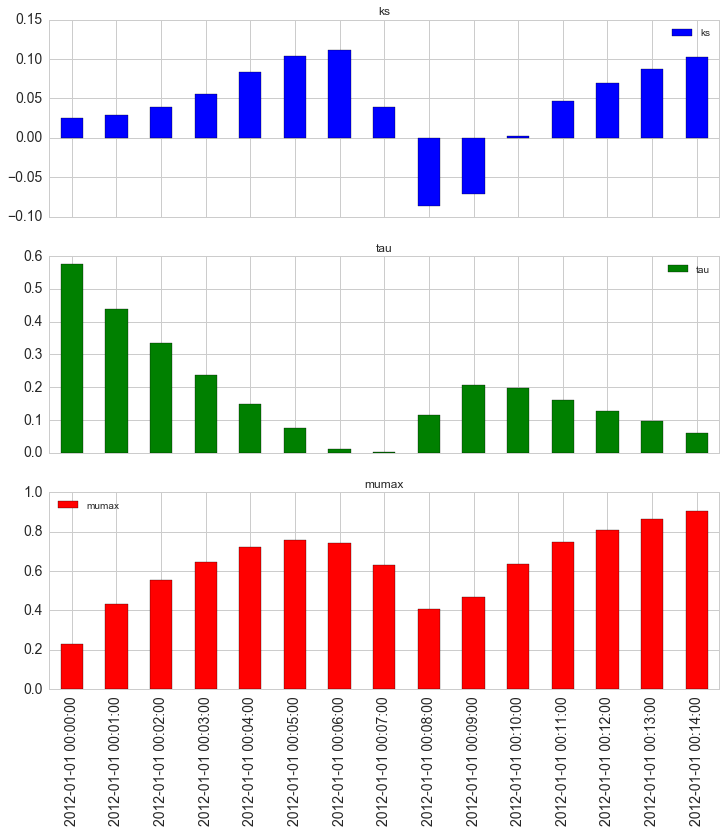

In [333]:
low_sis.sort_index().iloc[:15,:].plot(subplots=True, figsize=(12, 12), kind='bar')

In [ ]:
#low_sens = low_hp.get_recess().get_above_percentile(0.5)

In [ ]:
#sval_low = [] 
#for i in range(10000):
#    sval_low.append(low_sens.data.iloc[:,i].dropna().min())

In [ ]:
plt.hist(sval_low)

In [ ]:
respiro_sobol.SobolVariancePost(np.array(sval_low))

In [ ]:
respiro_sobol.plotSi()

In [ ]:
respiro_sobol.plotSTi()